# Search in PubMEd for full text and number of citations

by Stéphanie Fouteau and Naïa Périnelle

## packages required

launch this only one time

### Installations

In [ ]:
! pip install biopython
! pip install xlwt
! pip install seaborn
! pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.3 MB/s eta 0:00:00


### importations

In [ ]:
import Bio
print (Bio.__version__)

1.81


In [ ]:
from Bio import Entrez
import pandas as pd
import xlwt
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas

## Functions

### Define a function for performing the search

In [ ]:
# by Stéphanie Fouteau
# a function to ask the user one keyword
def search_pubmed(query):
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax='20',
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

In [ ]:
# Not used anymore

# a function to obtain all id of results in a list
def get_pmids(results):
    id_list = results['IdList']
    # or id_list = results.get('IdList')
    return id_list

### The next step is to fetch the details for all the retrieved articles via the efetch utility:

In [ ]:
# by Stéphanie Fouteau
def fetch_details(id_list):
    pmids = ','.join(id_list)
    handle = Entrez.efetch(db='pubmed', retmode='xml', id=pmids)
    results = Entrez.read(handle)
    return results

### Or summaryse informations about the Newspaper with pubmed ID:

---



In [ ]:
# by Stéphanie Fouteau
def get_summary(id_list):
    ids = ','.join(id_list)
    handle = Entrez.esummary(db="pubmed", id=ids)
    summary = Entrez.read(handle)
    return summary

### Finds free full-text articles in PMC that cite the specified PubMed articles

In [ ]:
# by Stéphanie Fouteau
def get_refs(pmid):
    """ input: pmid
        output: pmc_id list that input is cited by """
    handle = Entrez.elink(dbfrom="pubmed", db="pmc", LinkName="pubmed_pmc_refs", from_uid=pmid)
    results = Entrez.read(handle)
    pmcids = []
    refs_nb = 0
    if len(results[0]['LinkSetDb']) > 0:
        for link in results[0]['LinkSetDb'][0]['Link']:
            pmcids.append(link['Id'])
        refs_nb = len(pmcids)

    else:
        refs_nb = len(pmcids)

    return refs_nb

### Finds free full-text versions in PMC of specified articles cited in PubMed and extract it in pdf format

In [ ]:
# by Stéphanie Fouteau
def get_full_text(pmid):
    """ input: pmid
        output: pmc_id list that input is cited by """
    handle = Entrez.elink(dbfrom="pubmed", db="pmc", LinkName="pubmed_pmc", from_uid=pmid)
    results = Entrez.read(handle)
    if len(results[0]['LinkSetDb']) > 0:
        pmcid = results[0]['LinkSetDb'][0]['Link'][0]['Id']
        pdf = 'http://www.ncbi.nlm.nih.gov/pmc/articles/PMC' + pmcid + '/pdf/'
    else:
        pdf = 'NaN'

    return pdf

### sort by number of citations

In [ ]:
# by Naïa Périnelle
# a function to sort by the number of citations (order decreasing)
# return in the dataframe only the results with a full text
def df_sort_by_citations(dataframe):
  df_sorted_citations = dataframe.sort_values(by=['number of citations'], ascending=False)
  df_fulltext_by_citations = df_sorted_citations[df_sorted_citations['link to full text in pdf'] != 'NaN']
  return(df_fulltext_by_citations)

### plot

In [ ]:
# by Naïa Périnelle
def nb_citations_barplot(dataframe):
   # barplot : number of citations by article
    plot = sns.barplot(data=dataframe, x="PubMed Id", y="number of citations")
    for item in plot.get_xticklabels():
      item.set_rotation(80)
    return(plt.show(plot))

In [ ]:
# by Naïa Périnelle
def Newspaper_pie_chart(dataframe):
    # pie chart : number of article by newspaper
    df_Newspaper_count = dataframe.value_counts("Newspaper")
    pie_chart = df_Newspaper_count.plot.pie(y='Newspaper')
    return(plt.show(pie_chart),df_Newspaper_count)

### Main

In [ ]:
# by Naïa Périnelle
from pandas.core.frame import DataFrame
def launch_search_pubmed():
    # create a dictionnary
    data = {
        'Title': [],
        'PubMed Id': [],
        'First author': [],
        'Last author': [],
        'Publication date': [],
        'Newspaper':[],
        'DOI': [],
        'number of citations':[],
        'link to full text in pdf': []
    }

    # launch search pubmed
    Entrez.email = input("Give your email (your.email@example.com) : ")
    query = input("Give a keyword (search in the title of the article) : ")
      # max_result = int(input("How many result would you like ? "))
    results = search_pubmed(query)
    id_list = get_pmids(results)
    print(len(id_list))
    summary = get_summary(id_list)

    #Extract paper's informations
    for i in range(len(id_list)):
        pubmedID = summary[i]['Id']
        title = summary[i]['Title']
        doi = "http://doi.org/" + summary[i]['DOI'] # don't work for all article
                        #(ex : query = 'Single cell', retmax=100 doesn't work)
        pubDate = summary[i]['PubDate']
        Newspaper = summary[i]['Source']
        firstAuthor = summary[i]['AuthorList'][0]
        lastAuthor = summary[i]['LastAuthor']

        # Append informations in data
        data['Title'].append(title)
        data['PubMed Id'].append(pubmedID)
        data['First author'].append(firstAuthor)
        data['Last author'].append(lastAuthor)
        data['Publication date'].append(pubDate)
        data['Newspaper'].append(Newspaper)
        data['DOI'].append(doi)

    for pmid in id_list:
        refs_nb = get_refs(pmid)
        pdf = get_full_text(pmid)

        # Append informations in data
        data['number of citations'].append(refs_nb)
        data['link to full text in pdf'].append(pdf)

    # create dataframe
    dataframe = pd.DataFrame(data)

    # sort dataframe
    df_sorted = df_sort_by_citations(dataframe)

    # plot = dataframe.hvplot.bar(x="PubMed Id", y="number of citations", rot=45)
    return (dataframe, df_sorted)

Give your email (your.email@example.com) : your.email@example.com
Give a keyword (search in the title of the article) : Single cell
20


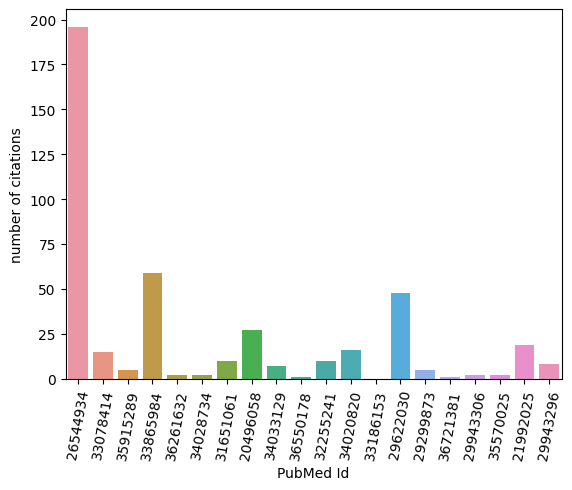

(None,
                                                Title PubMed Id First author  \
 0  Design and Analysis of Single-Cell Sequencing ...  26544934       Grün D   
 1  Single-cell molecular profiling provides a hig...  33078414     Hamey FK   
 2  Single-Cell RNA Sequencing: Unravelling the Bo...  35915289      Chai RC   
 3  A single cell atlas of human cornea that defin...  33865984     Collin J   
 4  Efficient and safe single-cell cloning of huma...  36261632   Tristan CA   
 
          Last author Publication date            Newspaper  \
 0  van Oudenaarden A       2015 Nov 5                 Cell   
 1          Dahlin JS         2021 Jun              Allergy   
 2            Chai RC         2022 Oct  Curr Osteoporos Rep   
 3             Lako M         2021 Jul            Ocul Surf   
 4           Singeç I         2023 Jan           Nat Protoc   
 
                                          DOI  number of citations  \
 0  http://doi.org/10.1016/j.cell.2015.10.039                

In [ ]:
# by Naïa Périnelle
dataframe, df_sorted = launch_search_pubmed()


nb_citations_barplot(dataframe), dataframe.head(), df_sorted

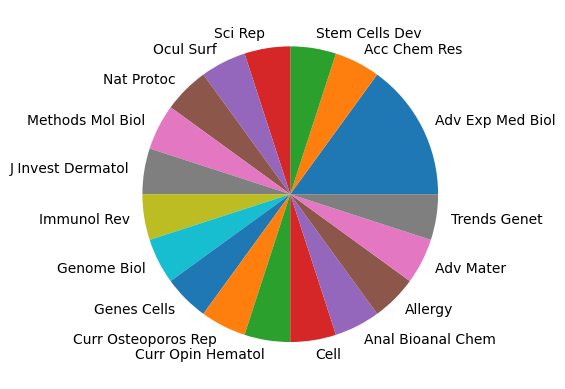

(None,
 Newspaper
 Adv Exp Med Biol       3
 Acc Chem Res           1
 Stem Cells Dev         1
 Sci Rep                1
 Ocul Surf              1
 Nat Protoc             1
 Methods Mol Biol       1
 J Invest Dermatol      1
 Immunol Rev            1
 Genome Biol            1
 Genes Cells            1
 Curr Osteoporos Rep    1
 Curr Opin Hematol      1
 Cell                   1
 Anal Bioanal Chem      1
 Allergy                1
 Adv Mater              1
 Trends Genet           1
 dtype: int64)

In [ ]:
# by Naïa Périnelle
Newspaper_pie_chart(dataframe)